## Train Test Split

We will be working with a data set based on [housing prices in Ames, Iowa](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

There are an extensive number of features, so they've been described in the table below.

### Predictor

* SalePrice: The property's sale price in dollars. 

### Features

* MoSold: Month Sold
* YrSold: Year Sold   
* SaleType: Type of sale
* SaleCondition: Condition of sale
* MSSubClass: The building class
* MSZoning: The general zoning classification
* ...


In [1]:
import pandas as pd
import numpy as np
 
data = pd.read_csv("Ames_Housing_Sales.csv")
 
# show the first 5 rows using dataframe.head() method
print("The first 5 rows of the dataframe") 
data.head(5)

The first 5 rows of the dataframe


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,NaN,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,NaN,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,NaN,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [2]:
data.dtypes.value_counts()

object     43
float64    21
int64      16
Name: count, dtype: int64

A significant challenge, particularly when dealing with data that have many columns, is ensuring each column gets encoded correctly. 

This is particularly true with data columns that are ordered categoricals (ordinals) vs unordered categoricals. Unordered categoricals should be one-hot encoded, however this can significantly increase the number of features and creates features that are highly correlated with each other.

Determine how many total features would be present, relative to what currently exists, if all string (object) features are one-hot encoded. Recall that the total number of one-hot encoded columns is `n-1`, where `n` is the number of categories.


In [3]:
# Select the object (string) columns
mask = data.dtypes == object
categorical_cols = data.columns[mask]

In [4]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

204

Let's create a new data set where all of the above categorical features will be one-hot encoded. We can fit this data and see how it affects the results.

* Used the dataframe `.copy()` method to create a completely separate copy of the dataframe for one-hot encoding
* On this new dataframe, one-hot encode each of the appropriate columns and add it back to the dataframe. Be sure to drop the original column.
* For the data that are not one-hot encoded, drop the columns that are string categoricals.

For the first step, numerically encoding the string categoricals, either Scikit-learn;s `LabelEncoder` or `DictVectorizer` can be used. However, the former is probably easier since it doesn't require specifying a numerical value for each category, and we are going to one-hot encode all of the numerical values anyway. (Can you think of a time when `DictVectorizer` might be preferred?)


In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [6]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

215

In [7]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

80
37


* Create train and test splits of both data sets. To ensure the data gets split the same way, use the same `random_state` in each of the two splits.
* For each data set, fit a basic linear regression model on the training data. 
* Calculate the mean squared error on both the train and test sets for the respective models. Which model produces smaller error on the test data and why?


In [8]:
from sklearn.model_selection import train_test_split

y_col = 'SalePrice'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [9]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [10]:
X_train

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
461,630.0,0.0,0.0,1,515.0,0.0,1,0,115.0,0.0,...,8,4,0.0,0.0,3,630.0,0.0,1970,2002,2009
976,845.0,0.0,0.0,3,0.0,0.0,0,0,0.0,0.0,...,3,4,0.0,0.0,5,0.0,186.0,1957,1957,2009
1128,728.0,728.0,0.0,3,0.0,0.0,0,0,728.0,0.0,...,5,6,0.0,0.0,8,728.0,100.0,2005,2005,2008
904,561.0,668.0,0.0,2,285.0,0.0,0,0,276.0,0.0,...,6,6,0.0,0.0,5,561.0,150.0,1980,1980,2009
506,1601.0,0.0,0.0,3,1358.0,0.0,1,0,223.0,0.0,...,5,8,0.0,0.0,6,1581.0,180.0,2001,2002,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,855.0,601.0,0.0,3,311.0,0.0,0,0,544.0,0.0,...,5,6,0.0,0.0,7,855.0,26.0,1978,1978,2010
1130,815.0,875.0,0.0,3,0.0,0.0,0,0,815.0,330.0,...,6,7,0.0,0.0,7,815.0,0.0,1916,1950,2006
1294,1661.0,0.0,0.0,3,831.0,0.0,1,0,161.0,0.0,...,6,6,0.0,178.0,8,992.0,0.0,1955,1996,2008
860,742.0,742.0,0.0,3,0.0,0.0,0,0,742.0,0.0,...,5,6,0.0,0.0,8,742.0,36.0,2005,2005,2009


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,1.131507e+09,3.177271e+08
test,1.372182e+09,4.344470e+16


Note that the error values on the one-hot encoded data are very different for the train and test data. In particular, the errors on the test data are much higher. This is because the one-hot encoded model is overfitting the data.


For each of the data sets (one-hot encoded and not encoded):

* Scale the all the non-hot encoded values using one of the following: `StandardScaler`, `MinMaxScaler`, `MaxAbsScaler`.
* Compare the error calculated on the test sets

Be sure to calculate the skew (to decide if a transformation should be done) and fit the scaler on *ONLY* the training data, but then apply it to both the train and test data identically.


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

In [13]:
scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        1.372182e+09
not_encoded - minmaxscaling          1.372187e+09
not_encoded - maxabsscaling          1.372272e+09
one_hot_encoded - standardscaling    3.007099e+25
one_hot_encoded - minmaxscaling      8.065328e+09
one_hot_encoded - maxabsscaling      8.065328e+09
--------------------------------------------------------------------------------
not_encoded - standardscaling 1372182358.9345148
not_encoded - minmaxscaling 1372187343.192181
not_encoded - maxabsscaling 1372271676.2656085
one_hot_encoded - standardscaling 3.007099345157518e+25
one_hot_encoded - minmaxscaling 8065327607.227743
one_hot_encoded - maxabsscaling 8065327607.235992


Plot predictions vs actual for one of the models.

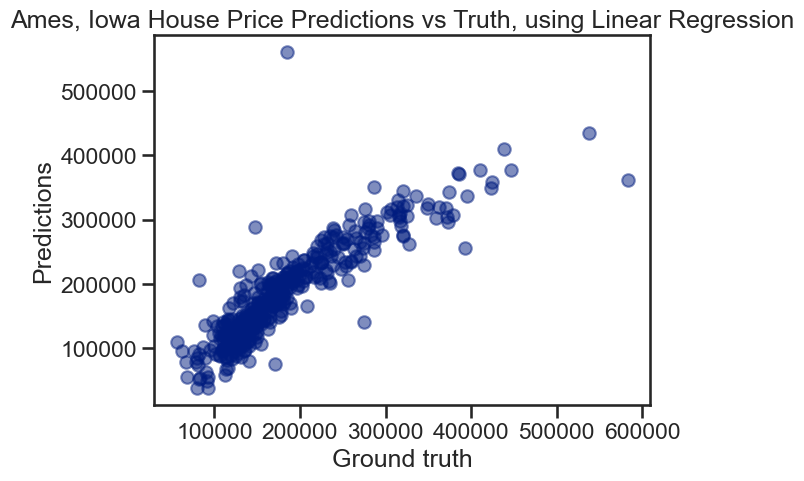

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Ames, Iowa House Price Predictions vs Truth, using Linear Regression');